In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm
import catboost
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.cluster import KMeans

In [5]:
from math import sqrt
def rmse(y_true,y_preds):
    return sqrt(mean_squared_error(y_true,y_preds))

In [6]:
Train = pd.read_csv('Train.csv')
Test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [7]:
Train.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


In [31]:
group = Train.groupby('site')

In [35]:
group.groups.keys()

dict_keys(['Makerere', 'Nakawa', 'USEmbassy'])

In [54]:
US_mean = int(group.get_group('USEmbassy')['ref_pm2_5'].mean())
MK_mean = int(group.get_group('Makerere')['ref_pm2_5'].mean())
NK_mean = int(group.get_group('Nakawa')['ref_pm2_5'].mean())

In [55]:
for _,__ in zip([US_mean,MK_mean,NK_mean],['US Mean:', 'Makerere Mean:','Nakawa Mean:']):
    print(__,_)

US Mean: 60
Makerere Mean: 39
Nakawa Mean: 50


In [65]:
US_rel_avg = round(group.get_group('USEmbassy')['ref_pm2_5'].sum()/Train['ref_pm2_5'].sum(),1)
MK_rel_avg = round(group.get_group('Makerere')['ref_pm2_5'].sum()/Train['ref_pm2_5'].sum(),1)
NK_rel_avg = round(group.get_group('Nakawa')['ref_pm2_5'].sum()/Train['ref_pm2_5'].sum(),1)

In [93]:
mag_vals_avg = {'USEmbassy':US_mean,'Makerere':MK_mean,'Nakawa':NK_mean}

In [100]:
data['ref_vals'] = all_data['site'].map(mag_vals_avg)
#apply(lambda val: mag_vals.avgb )

In [95]:
all_data

,ID,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_270m,population,dist_major_road,created_at_year,created_at_day,created_at_date,created_at_month,created_at_quarter,created_at_hour,ref_vals
0,ID_0038MG0B,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,...,14,6834,130,2020,Thursday,23,4,2,17,60
1,ID_008ASVDD,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,...,14,6834,130,2020,Sunday,23,2,1,19,60
2,ID_009ACJQ9,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,...,-11,4780,500,2021,Saturday,23,1,1,4,50
3,ID_00IGMAQ2,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,...,14,6834,130,2019,Wednesday,4,12,4,9,60
4,ID_00P76VAQ,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,...,14,6834,130,2019,Tuesday,1,10,4,1,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,ID_ZW5RSNUS,Makerere,43.508889,53.786667,42.747778,53.457778,0.924833,22.358333,0.333501,32.568561,...,28,8518,475,2021,Thursday,18,2,1,3,39
2729,ID_ZWCI817N,Nakawa,101.348049,114.076098,99.469512,116.441220,0.936333,20.500000,0.331740,32.609510,...,-11,4780,500,2021,Thursday,21,1,1,23,50
2730,ID_ZX5858FJ,Makerere,47.248182,59.862727,46.526364,59.971818,0.857917,20.966667,0.333501,32.568561,...,28,8518,475,2020,Saturday,12,12,4,21,39
2731,ID_ZY4XOL2H,USEmbassy,217.070465,264.880698,220.803488,249.663953,0.716833,22.158333,0.299255,32.592686,...,14,6834,130,2021,Monday,8,2,1,2,60


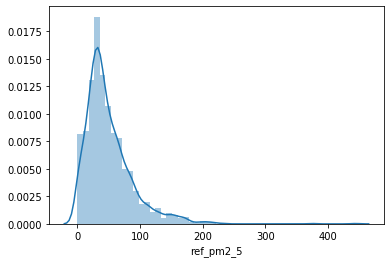

In [85]:
sns.distplot(Train[Train['site'] == 'Nakawa']['ref_pm2_5'])

In [51]:
Train[Train['ref_pm2_5'] > 50]['site'].value_counts()

USEmbassy    3006
Makerere      788
Nakawa        655
Name: site, dtype: int64

In [53]:
Train[Train['site'] == 'Nakawa']['ref_pm2_5']

2        149.7
11        21.1
13        20.4
14        26.0
21        70.2
         ...  
10906     24.3
10914     27.5
10915     19.9
10920    110.8
10926     25.6
Name: ref_pm2_5, Length: 1717, dtype: float64

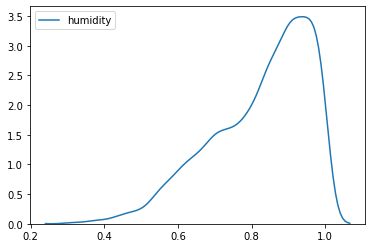

In [9]:
sns.kdeplot(Train['humidity'])

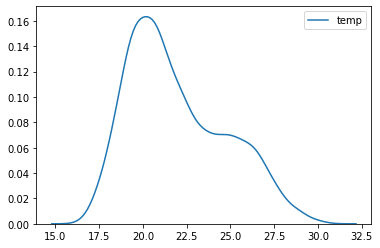

In [10]:
sns.kdeplot(Train['temp'])

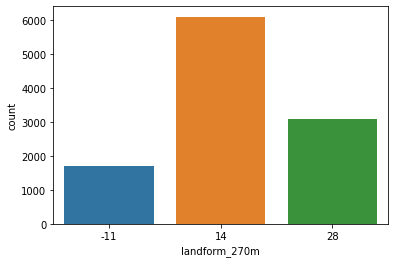

In [11]:
sns.countplot(Train.landform_270m)

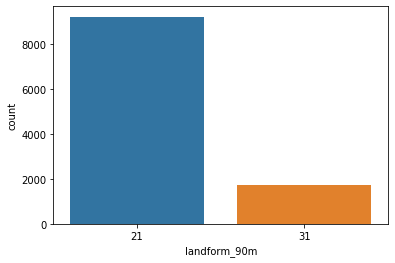

In [12]:
sns.countplot(Train.landform_90m)

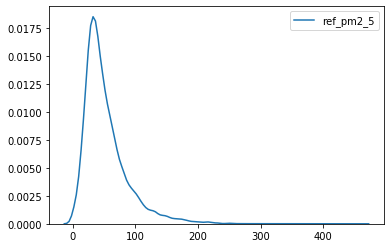

In [13]:
sns.kdeplot(Train['ref_pm2_5'])

In [96]:
data = pd.concat([Train,Test]).drop('ref_pm2_5', axis=1)

In [15]:
data.shape,Train.shape,Test.shape

((13665, 17), (10932, 18), (2733, 17))

In [16]:
ntrain = Train.shape[0]
ntest = Test.shape[0]

In [97]:
data.columns

Index(['ID', 'created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road'],
      dtype='object')

In [18]:
cat_feats = ['landform_270m', 'landform_90m', 'site']
num_feats = ['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 
             'greenness','population', 'dist_major_road']

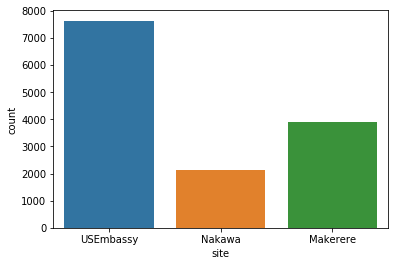

In [19]:
sns.countplot(data['site'])

In [20]:
time = pd.to_datetime(data.created_at.iloc[1])

In [21]:
time

Timestamp('2020-02-23 19:00:00+0300', tz='pytz.FixedOffset(180)')

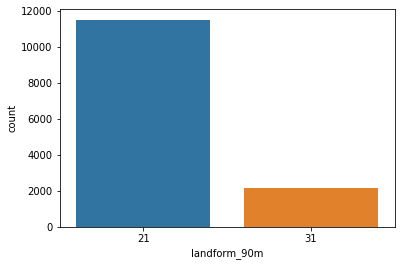

In [22]:
sns.countplot(data['landform_90m'])

In [98]:
data['created_at'] = pd.to_datetime(data['created_at'])

In [99]:
def extract_date_info(df,cols,):
    X = df.copy()
    for feat in cols:
        X[f'{feat}_year'] = X[feat].dt.year
        X[f'{feat}_day'] = X[feat].dt.day_name()
        X[f'{feat}_date'] = X[feat].dt.day
        X[f'{feat}_month'] = X[feat].dt.month
        X[f'{feat}_quarter'] = X[feat].dt.quarter
        X[f'{feat}_hour'] = X[feat].dt.hour
        
        #X[f'{feat}_is_month_end'] = X[feat].dt.is_month_end
    X.drop(columns=cols,axis=1, inplace=True)
    
    return X

In [25]:
all_data = extract_date_info(data,['created_at',])

In [101]:
all_data['created_at_day']

0        Thursday
1          Sunday
2        Saturday
3       Wednesday
4         Tuesday
          ...    
2728     Thursday
2729     Thursday
2730     Saturday
2731       Monday
2732       Monday
Name: created_at_day, Length: 13665, dtype: object

In [27]:
all_data.columns

Index(['ID', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10', 'humidity',
       'temp', 'lat', 'long', 'altitude', 'greenness', 'landform_90m',
       'landform_270m', 'population', 'dist_major_road', 'created_at_year',
       'created_at_day', 'created_at_date', 'created_at_month',
       'created_at_quarter', 'created_at_hour'],
      dtype='object')

In [102]:
cat_feats = ['landform_270m', 'landform_90m', 'site','created_at_day']
num_feats = ['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 
             'greenness','population', 'dist_major_road','created_at_date', 'created_at_month',
       'created_at_quarter', 'created_at_hour']

In [103]:
dummied_data = pd.get_dummies(all_data, columns=cat_feats)

In [104]:
dummied_data.head()

,ID,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,...,site_Makerere,site_Nakawa,site_USEmbassy,created_at_day_Friday,created_at_day_Monday,created_at_day_Saturday,created_at_day_Sunday,created_at_day_Thursday,created_at_day_Tuesday,created_at_day_Wednesday
0,ID_0038MG0B,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,...,0,0,1,0,0,0,0,1,0,0
1,ID_008ASVDD,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,...,0,0,1,0,0,0,1,0,0,0
2,ID_009ACJQ9,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,...,0,1,0,0,0,1,0,0,0,0
3,ID_00IGMAQ2,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,...,0,0,1,0,0,0,0,0,0,1
4,ID_00P76VAQ,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,...,0,0,1,0,0,0,0,0,1,0


In [105]:
def Train_Evaluate(models,train_data,target, val_metric=rmse, test_data=None,params=None):
    
    train_score_sheet = {}
    val_score_sheet = {}
    named_models = {}
    names = []
    preds_val = {}
    predictions = {}
    idx = 0
    
        
    for name, model in models.items():
        named_models[name] = model
        
        if params != None:
            if name in params.keys():
                pass
        
        print('====={}===============Training: {}=========================='.format(idx+1,name))
        if type(model) == type(lightgbm.LGBMRegressor()):
            predictions[name], preds_val[name],train_score_sheet[name], val_score_sheet[name], named = LGBMTrain(model,train_data,target,test_data,name)
            names.append(named)
        
        elif type(model) == type(xgb.XGBRegressor()):
            predictions[name],preds_val[name],train_score_sheet[name], val_score_sheet[name], named = XGBTrain(model,train_data,target, test_data, name)
        
        elif type(model) == type(catboost.CatBoostRegressor()):
            
            predictions[name],preds_val[name],train_score_sheet[name], val_score_sheet[name], named  = CatBoostTrain(model,train_data,target,test_data, name)
            
        else:
            
            mean_train_scores = []
            mean_val_scores = []
            val_pred = np.zeros(train_data.shape[0])
            test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
            impute = SimpleImputer(strategy = 'mean')
            train_set = pd.DataFrame(impute.fit_transform(train_data), columns=train_data.columns)
            test_set =  pd.DataFrame(impute.transform(test_data), columns=test_data.columns)
            
            for index, (train_index, val_index) in enumerate(skf.split(train_set,target)):

                print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
                x_train , x_test = train_set.iloc[train_index], train_set.iloc[val_index]
                y_train, y_test = target.iloc[train_index], target.iloc[val_index]

                model.fit(x_train,y_train)

                train_predict = model.predict(x_train)
                preds = model.predict(x_test)
                val_pred[val_index] = preds
                test_pred[index] = model.predict(test_set)

                mean_train_scores.append(val_metric(y_train,train_predict))
                mean_val_scores.append(val_metric(y_test,preds))
                print('\nValidation Score :::> ', val_metric(y_test,preds))
                print('\nTraining Score   :::> ', val_metric(y_train, train_predict))
            test_predictions = np.mean(test_pred.T, axis=1)
            predictions[name] = test_predictions
            preds_val[name] = val_pred[:]
            train_score_sheet[name] = np.mean(mean_train_scores)
            val_score_sheet[name] = np.mean(mean_val_scores)
            print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
            print('\nAverage Validation Score ::>', np.mean(mean_val_scores))            
            
                      
        idx+=1
            
    return train_score_sheet, val_score_sheet, named_models,preds_val, predictions

In [106]:
def LGBMTrain(model,train_data,target,test_data, name):
    mean_train_scores = []
    mean_val_scores = []
    val_pred = np.zeros(train_data.shape[0])
    test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
    for index, (train_index, val_index) in enumerate(skf.split(train_data,target)):

        print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
        x_train , x_test = train_data.iloc[train_index], train_data.iloc[val_index]
        y_train, y_test = target.iloc[train_index], target.iloc[val_index]

        model.fit(x_train,y_train, eval_set=(x_test,y_test), eval_metric = 'auc', verbose= 50)

        train_predict = model.predict(x_train, num_iterations=model.best_iteration_)
        lgb_preds = model.predict(x_test, num_iterations = model.best_iteration_)
        val_pred[val_index] = lgb_preds
        test_pred [index] = model.predict(test_data, num_iterations = model.best_iteration_)

        mean_train_scores.append(rmse(y_train,train_predict))
        mean_val_scores.append(rmse(y_test,lgb_preds))
        print('\nValidation Score :::> ', rmse(y_test,lgb_preds))
        print('\nTraining Score   :::> ', rmse(y_train, train_predict))


    print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
    print('\nAverage Validation Score ::>', np.mean(mean_val_scores))
    test_predictions = np.mean(test_pred.T, axis=1)
    
    return test_predictions,val_pred, np.mean(mean_train_scores), np.mean(mean_val_scores), name



def XGBTrain(model,train_data,target,test_data, name):
    mean_train_scores = []
    mean_val_scores = []
    val_pred = np.zeros(train_data.shape[0])
    test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
    
    for index, (train_index, val_index) in enumerate(skf.split(train_data,target)):

        print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
        x_train , x_test = train_data.iloc[train_index], train_data.iloc[val_index]
        y_train, y_test = target.iloc[train_index], target.iloc[val_index]

        model.fit(x_train,y_train, eval_set=[(x_test,y_test)], eval_metric = 'rmse', verbose= 50, early_stopping_rounds=200)

        train_predict = model.predict(x_train, ntree_limit = model.get_booster().best_ntree_limit)
        xgb_preds = model.predict(x_test, ntree_limit = model.get_booster().best_ntree_limit)
        val_pred[val_index] = xgb_preds
        test_pred [index] = model.predict(test_data, ntree_limit = model.get_booster().best_ntree_limit)

        mean_train_scores.append(rmse(y_train,train_predict))
        mean_val_scores.append(rmse(y_test,xgb_preds))
        print('\nValidation Score :::> ', rmse(y_test,xgb_preds))
        print('\nTraining Score   :::> ', rmse(y_train, train_predict))


    print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
    print('\nAverage Validation Score ::>', np.mean(mean_val_scores))
    test_predictions =  np.mean(test_pred.T, axis=1)
    
    return test_predictions,val_pred, np.mean(mean_train_scores), np.mean(mean_val_scores), name


def CatBoostTrain(model,train_data,target,test_data, name):
    mean_train_scores = []
    mean_val_scores = []
    val_pred = np.zeros(train_data.shape[0])
    test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
    for index, (train_index, val_index) in enumerate(skf.split(train_data,target)):

        print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
        print('Now using catboos')
        x_train , x_test = train_data.iloc[train_index], train_data.iloc[val_index]
        y_train, y_test = target.iloc[train_index], target.iloc[val_index]

        model.fit(x_train,y_train, eval_set=(x_test,y_test), verbose= 50)

        train_predict = model.predict_proba(x_train)[:,1]
        cat_preds = model.predict_proba(x_test)[:,1]
        val_pred[val_index] = cat_preds
        test_pred += model.predict_proba(test_data)[:,1]

        mean_train_scores.append(rmse(y_train,train_predict))
        mean_val_scores.append(rmse(y_test,cat_preds))
        print('\nValidation Score :::> ', rmse(y_test,cat_preds))
        print('\nTraining Score   :::> ', rmse(y_train, train_predict))


    print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
    print('\nAverage Validation Score ::>', np.mean(mean_val_scores))
    
    
    return  np.mean(test_pred.T, axis=1),val_pred, np.mean(mean_train_scores), np.mean(mean_val_scores), name


In [88]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10932 entries, 0 to 10931
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10932 non-null  object 
 1   created_at       10932 non-null  object 
 2   site             10932 non-null  object 
 3   pm2_5            10932 non-null  float64
 4   pm10             10932 non-null  float64
 5   s2_pm2_5         10932 non-null  float64
 6   s2_pm10          10932 non-null  float64
 7   humidity         10926 non-null  float64
 8   temp             10915 non-null  float64
 9   lat              10932 non-null  float64
 10  long             10932 non-null  float64
 11  altitude         10932 non-null  int64  
 12  greenness        10932 non-null  int64  
 13  landform_90m     10932 non-null  int64  
 14  landform_270m    10932 non-null  int64  
 15  population       10932 non-null  int64  
 16  dist_major_road  10932 non-null  int64  
 17  ref_pm2_5   

In [107]:
Target = Train['ref_pm2_5']
train = dummied_data[:ntrain].drop(['ID'], axis=1)
test = dummied_data[ntrain:].drop(['ID'], axis=1)

In [108]:
set(train.columns == test.columns)

{True}

In [109]:
from sklearn.model_selection import KFold

In [110]:
skf =KFold(n_splits=10,random_state=42 )

In [111]:
models = {'XGB': xgb.XGBRegressor(random_state=45, n_estimators=500),
         'LGBM': lightgbm.LGBMRegressor(random_state=45),}

model = {'LGBM': lightgbm.LGBMRegressor(random_state=45),}
train_scores, val_scores, named_models,preds_val, preds = Train_Evaluate(model,train, Target,
                                                              test_data=test)

=====1===============Training: LGBM==========================

==========================>**Fold 1**<================================


[50]	valid_0's auc: 1	valid_0's l2: 141.593
[100]	valid_0's auc: 1	valid_0's l2: 129.197

Validation Score :::>  11.366507324488236

Training Score   :::>  9.739914794008738

==========================>**Fold 2**<================================


[50]	valid_0's auc: 1	valid_0's l2: 185.227
[100]	valid_0's auc: 1	valid_0's l2: 166.399

Validation Score :::>  12.8995632393316

Training Score   :::>  9.63927741526281

==========================>**Fold 3**<================================


[50]	valid_0's auc: 1	valid_0's l2: 257.331
[100]	valid_0's auc: 1	valid_0's l2: 243.328

Validation Score :::>  15.598968246744933

Training Score   :::>  9.356572055902912

==========================>**Fold 4**<================================


[50]	valid_0's auc: 1	valid_0's l2: 239.416
[100]	valid_0's auc: 1	valid_0's l2: 220.585

Validation Score :::>  14.8521152

In [112]:
val_scores, train_scores

({'LGBM': 12.456453361064508}, {'LGBM': 9.600755346721403})

In [90]:
arr= []
for val in preds.values():
    arr.append(val[:])

In [92]:
np.array(arr)

[array([ 36.68832016,  43.71301117,  45.57909012, ...,  35.24910583,
        245.85469971, 100.16177292]),
 array([ 36.48663279,  44.68613865,  44.89071536, ...,  35.51820736,
        230.36819117,  99.87752045])]

In [114]:
submit = Test[['ID']]
submit['target'] = preds['LGBM']

submit.to_csv('Submission_LGBM.csv', index=False)